# 3D Resnet model to run on GPU

In this model, we only work with classes 1 and 2, not class 0 (rest).

All you have to do is define the folder paths so they match your machine, as well as define the parameters.

I advise you to use a variable learning rate (i.e a learning rate schedule) to avoid overfitting. As soon as you see that the validation loss stagnates, divide the learning rate by 10. By default this notebook is setup with a fixed learning rate.

## 1. Load the data

In [ ]:
pip install tensorflow==1.15 git+https://github.com/mtchibozo/keras-resnet3d.git

  Cloning https://github.com/mtchibozo/keras-resnet3d.git to /tmp/pip-req-build-z1qnp5o9
  Running command git clone -q https://github.com/mtchibozo/keras-resnet3d.git /tmp/pip-req-build-z1qnp5o9
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 412.3MB 40kB/s 
     |████████████████████████████████| 3.8MB 47.2MB/s 
     |████████████████████████████████| 512kB 47.3MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
  Created wheel for keras-resnet3d: filename=keras_resnet3d-0.0.1-cp37-none-any.whl size=4820 sha256=a4edd84805f7587169b5f5426dce83f02ab3f97133f5b5668fdc3fc6be908f5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-3mz930zb/wheels/14/77/25/058ad09e60fbb3058e46cc46ba860e21406b852552970b6fd7
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=9f66590713567e7e899a61ce5676179bf056dbfa00d146ac19d37d0e5deb5540
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a

In [ ]:
#pip install tensorflow==1.15 keras=2.3.1 https://github.com/JihongJu/keras-resnet3d.git

In [1]:
#ignore if you are not using Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#TODO
#Adjust path and parameters

#define paths according to your setup
folder_root = '/content/drive/My Drive/BrainStateClassification/3D_CNN_Cross-Subject/'#Update to your main folder, this folder must contain a data and a result subfolder
folder_data = folder_root + 'data/' #folder containing all the .mat files
folder_result = folder_root + 'result/' + 'resnet50/' #folder where your models and logs will be stored

#define key parameters of the model
n_runs = 39 #number of runs that will be selected for training, validation and testing - 39 runs in total
nlabels = 2   #negative vs. neutral



In [3]:
from os import listdir
import os
from scipy.io import loadmat
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow.compat.v1.keras as keras

import random
import time
import re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

Instructions for updating:
non-resource variables are not supported in the long term


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Load the data into a train, val and test set

os.chdir(folder_data)
file_list = shuffle(listdir(),random_state=0)[:n_runs]#only take n_runs files
print(file_list)
print("2 classes")
X = []
y = []
for root in file_list:
  data = loadmat(root)  #300, 60
  non_zeros = np.argwhere(data['labels'] != [0])[:,0]
  X += list(data['I'][0][non_zeros])
  y += list(data['labels'][non_zeros].flatten())
  non_zeros = []

  non_zeros = np.argwhere(data['labels_test'] != [0])[:,0]
  X += list(data['I_test'][0][non_zeros])
  y += list(data['labels_test'][non_zeros].flatten())
  non_zeros = []  

X = np.array(X)
y = np.array([y[i]-1 for i in range(len(y))]) #In the .mat files, there are 3 classes: 0,1,2. Here we use only classes 1 and 2 and convert them to 0,1 for the CNN to work correctly

print('nb. samples: ',len(y))

#save RAM
raw_data, raw_label = [], []

X_trainval, X_test, y_trainval, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=0)
X, y = [], []#save RAM

X_train, X_val, y_train, y_val = train_test_split(X_trainval,y_trainval, test_size=0.2,stratify=y_trainval,random_state=0)
X_trainval, y_trainval = [], [] #save RAM

print('train bin count : ',np.bincount(y_train.astype('int')))
print('val bin count : ',np.bincount(y_val.astype('int')))
print('test bin count : ',np.bincount(y_test.astype('int')))

train_bincount = np.bincount(y_train.astype('int'))

class_percentage = [train_bincount[0]/(train_bincount[0]+train_bincount[1]),train_bincount[1]/(train_bincount[0]+train_bincount[1])]
print('class frequency : ',class_percentage)


y_train = keras.utils.to_categorical(y_train,2)
y_val = keras.utils.to_categorical(y_val,2)
y_test = keras.utils.to_categorical(y_test,2)

#y_train = keras.utils.to_categorical(y_train,2).T
#y_val = keras.utils.to_categorical(y_val,2).T
#y_test = keras.utils.to_categorical(y_test,2).T

X_train = X_train.reshape(-1,64,64,44,1)
X_val = X_val.reshape(-1,64,64,44,1)
X_test = X_test.reshape(-1,64,64,44,1)

print(X_train.shape)
print(y_train.shape)

['E13281_run7_3D_wholeBrain_allConds.mat', 'E14163_run16_3D_wholeBrain_allConds.mat', 'E14163_run8_3D_wholeBrain_allConds.mat', 'E14133_run8_3D_wholeBrain_allConds.mat', 'E14133_run7_3D_wholeBrain_allConds.mat', 'E13571_run8_3D_wholeBrain_allConds.mat', 'E13341_run9_3D_wholeBrain_allConds.mat', 'E13502_run8_3D_wholeBrain_allConds.mat', 'E13325_run13_3D_wholeBrain_allConds.mat', 'E14178_run10_3D_wholeBrain_allConds.mat', 'E13553_run8_3D_wholeBrain_allConds.mat', 'E13495_run7_3D_wholeBrain_allConds.mat', 'E13265_run8_3D_wholeBrain_allConds.mat', 'E13905_run16_3D_wholeBrain_allConds.mat', 'E13544_run8_3D_wholeBrain_allConds.mat', 'E14081_run6_3D_wholeBrain_allConds.mat', 'E13571_run7_3D_wholeBrain_allConds.mat', 'E14097_run9_3D_wholeBrain_allConds.mat', 'E13349_run7_3D_wholeBrain_allConds.mat', 'E13301_run8_3D_wholeBrain_allConds.mat', 'E13473_run7_3D_wholeBrain_allConds.mat', 'E13553_run9_3D_wholeBrain_allConds.mat', 'E13495_run8_3D_wholeBrain_allConds.mat', 'E14146_run8_3D_wholeBrain_al

## ResNet - Keras

Underfitting starts before 7.5e-3 (0.0075)

In [ ]:
from resnet3d import Resnet3DBuilder
#import tensorflow.keras as keras

model_type = 'resnet50_'

reduce_lr_rate = 0.3
learning_rate = 'adam_reduce_lr_rate'+str(reduce_lr_rate)#1e-5
num_epochs = 1000

for regularisation in [5e-3]:
    path_prefix = folder_result + model_type +'first_'+str(n_runs)+'runs_lr_'+str(learning_rate) + '_reg'+ str(regularisation) + '_num_epochs'+str(num_epochs)

    checkpoint_path = folder_result + 'saved_models/' +  model_type +'first_'+str(n_runs)+'runs_lr_'+str(learning_rate) + '_reg'+ str(regularisation) + '_num_epochs'+str(num_epochs) + '_weights.best.hdf5'
    csv_logger_path = path_prefix + '.csv'

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=reduce_lr_rate,
        patience=30,
        verbose=1,
        mode="auto",
        min_delta=0.0001,
        cooldown=0,
        min_lr=5e-10)


    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True,
        save_weights_only=True, mode='max') # val_acc for tf.keras, val_accuracy for keras

    csv_logger = tf.keras.callbacks.CSVLogger(csv_logger_path, append=True, separator=';')

    if model_type == 'resnet101_':
      model = Resnet3DBuilder.build_resnet_101(input_shape=(64, 64, 44, 1), num_outputs=2, reg_factor=regularisation)


    if model_type == 'resnet50_':
      model = Resnet3DBuilder.build_resnet_50(input_shape=(64, 64, 44, 1), num_outputs=2, reg_factor=regularisation)


    if model_type == 'resnet34_':
      model = Resnet3DBuilder.build_resnet_34(input_shape=(64, 64, 44, 1), num_outputs=2, reg_factor=regularisation)

    model.compile(optimizer="adam",
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, 
              y_train, 
              batch_size=32,
              epochs=num_epochs,
              validation_data=(X_val, y_val),
              callbacks=[reduce_lr,csv_logger,checkpoint],
              verbose=1)

    print("Evaluate on test data")
    results = model.evaluate(X_test, y_test, batch_size=32)
    print("test loss, test acc:", results)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 1950 samples, validate on 488 samples
Epoch 1/1000
1920/1950 [============================>.] - ETA: 0s - loss: 117.4748 - acc: 0.5047
Epoch 00001: val_acc improved from -inf to 0.50410, saving model to /content/drive/My Drive/BrainStateClassification/3D_CNN_Cross-Subject/result/resnet50/resnet50_first_39runs_lr_adam_reduce_lr_rate0.3_reg0.005_num_epochs1000_weights.best.hdf5
1950/1950 [==============================] - 67s 34ms/sample - loss: 116.4760 - acc: 0.5021 - val_loss: 51.7866 - val_acc: 0.5041
Epoch 2/1000
1920/1950 [============================>.] - ETA: 0s - loss: 30.5255 - acc: 0.5156
Epoch 00002: val_acc improved from 0.50410 to 0.51639, saving model to /content/drive/My Drive/BrainStateClassification/3D_CNN_Cross-Subject/result/resnet50/resnet50_first_39runs_lr_adam_reduce_lr_rate0.3_reg0.005_num_epochs1000_weights.best.hdf5
1950/1950 [==============================] - 31s 16ms/samp

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = path_prefix + '_history.json'

with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## STOP HERE ##

next will be efficientnet


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

KeyError: ignored

In [4]:
model_type = 'resnet50_'

reduce_lr_rate = 0.3
learning_rate = 'adam_reduce_lr_rate'+str(reduce_lr_rate)#1e-5
num_epochs = 1250

for regularisation in [2e-4]:#, 9e-4, 1.25e-3, 2.5e-3, 5e-3]:
    path_prefix = folder_result + model_type +'first_'+str(n_runs)+'runs_lr_'+str(learning_rate) + '_reg'+ str(regularisation) + '_num_epochs'+str(num_epochs)

    checkpoint_path = path_prefix + '_weights.best.hdf5'
    csv_logger_path = path_prefix + '.csv'

import pandas as pd 

resnet_df = pd.read_csv(csv_logger_path,sep=";")
resnet_df = resnet_df[resnet_df.epoch > 200]
resnet_df['epoch'] = resnet_df['epoch'].apply(lambda x: x-200)

In [5]:
resnet_df

,epoch,acc,loss,lr,val_acc,val_loss
201,1,0.509744,0.696477,9.000000e-05,0.448771,0.699876
202,2,0.513333,0.695643,9.000000e-05,0.463115,0.698440
203,3,0.515897,0.695703,9.000000e-05,0.459016,0.699117
204,4,0.509231,0.695851,9.000000e-05,0.446721,0.702324
205,5,0.505128,0.695300,9.000000e-05,0.442623,0.699401
...,...,...,...,...,...,...
1245,1045,0.790769,0.411701,1.000000e-09,0.729508,0.569552
1246,1046,0.780000,0.421988,1.000000e-09,0.727459,0.569788
1247,1047,0.776923,0.424859,1.000000e-09,0.727459,0.569947
1248,1048,0.775897,0.415257,1.000000e-09,0.727459,0.569088


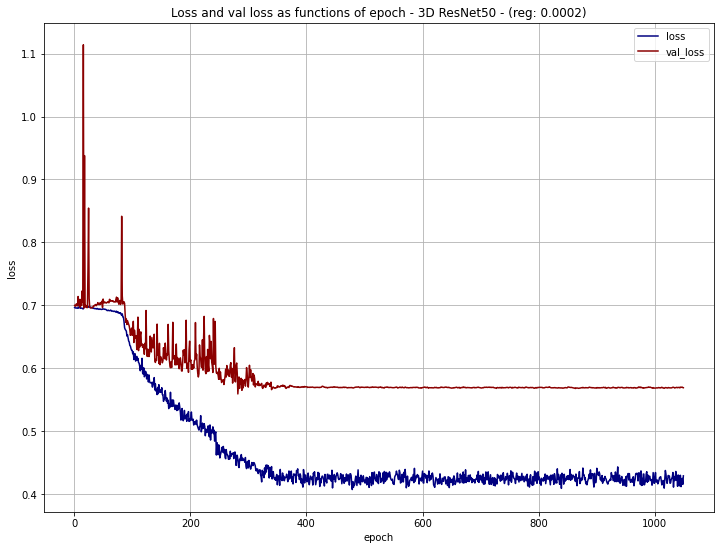

In [6]:
plt.figure(figsize=(12,9))
plt.plot(resnet_df["epoch"],resnet_df["loss"],color='navy',label='loss')
plt.plot(resnet_df["epoch"],resnet_df["val_loss"],color='darkred',label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.title('Loss and val loss as functions of epoch - 3D ResNet50 - (reg: '+str(regularisation)+')')
#plt.yticks(np.arange(0.3,1,0.1))
#plt.savefig(path_prefix + '_loss' +'.png')
plt.show()


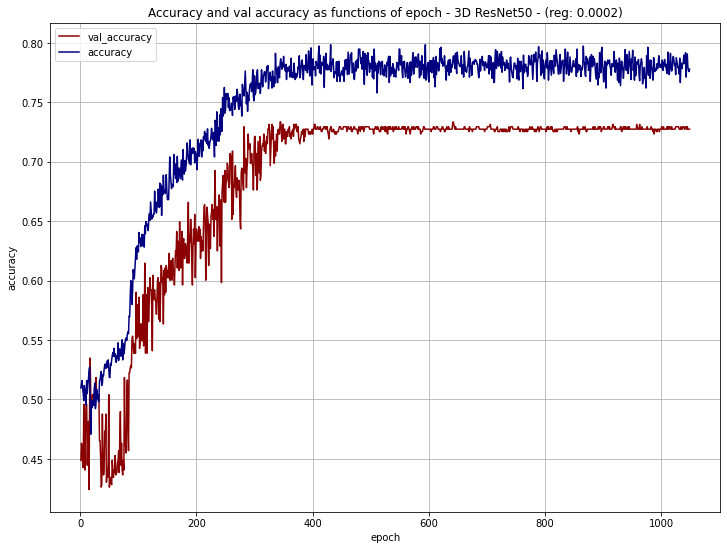

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(resnet_df["epoch"],resnet_df["val_acc"],color='darkred',label='val_accuracy')
plt.plot(resnet_df["epoch"],resnet_df["acc"],color='navy',label='accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.title('Accuracy and val accuracy as functions of epoch - 3D ResNet50 - (reg: ' + str(regularisation) + ')')
#plt.savefig(path_prefix + '_acc' +'.png')
plt.show()

In [13]:
path_prefix

'/content/drive/My Drive/BrainStateClassification/3D_CNN_Cross-Subject/result/resnet50/resnet50_first_39runs_lr_adam_reduce_lr_rate0.3_reg0.0002_num_epochs1250'

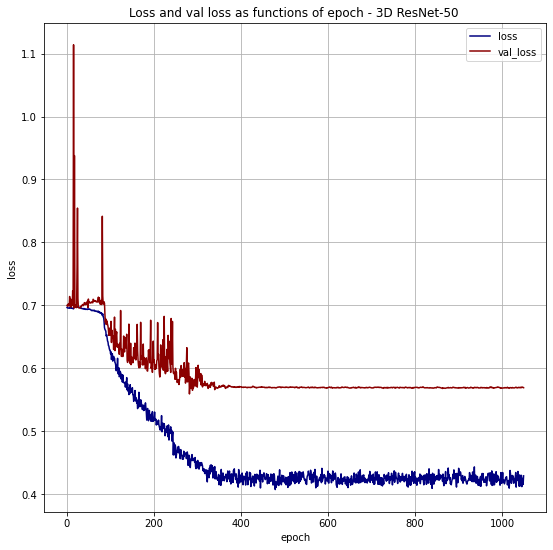

In [11]:
plt.figure(figsize=(9,9))
plt.plot(resnet_df["epoch"],resnet_df["loss"],color='navy',label='loss')
plt.plot(resnet_df["epoch"],resnet_df["val_loss"],color='darkred',label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.title('Loss and val loss as functions of epoch - 3D ResNet-50 ')
#plt.yticks(np.arange(0.3,1,0.1))
#plt.savefig(path_prefix + '_updated_loss' +'.png')
plt.show()

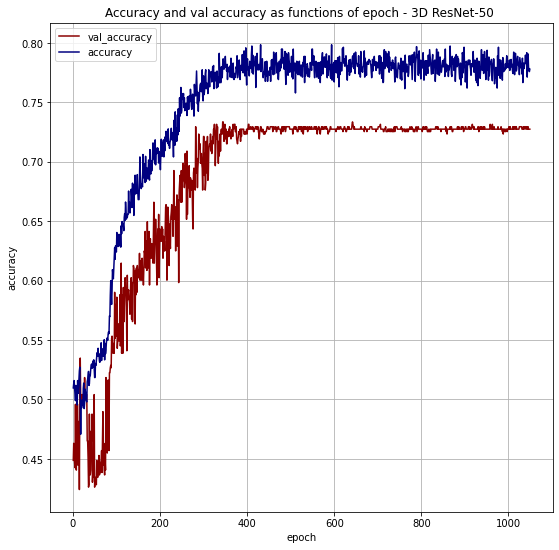

In [12]:
plt.figure(figsize=(9,9))
plt.plot(resnet_df["epoch"],resnet_df["val_acc"],color='darkred',label='val_accuracy')
plt.plot(resnet_df["epoch"],resnet_df["acc"],color='navy',label='accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.title('Accuracy and val accuracy as functions of epoch - 3D ResNet-50 ')
#plt.savefig(path_prefix + '_updated_acc' +'.png')
plt.show()

Load model for ROC 

In [ ]:
resnet50_first_39runs_lr_adam_reduce_lr_rate0.3_reg0.0005_num_epochs1250_weights.best

In [ ]:
from resnet3d import Resnet3DBuilder

#import tensorflow.keras as keras

model_type = 'resnet50_'

reduce_lr_rate = 0.3
learning_rate = 'adam_reduce_lr_rate'+str(reduce_lr_rate)#1e-5
num_epochs = 1250

for regularisation in [2e-4]:

    load_model_path = folder_result +  model_type +'first_'+str(n_runs)+'runs_lr_'+str(learning_rate) + '_reg'+ str(regularisation) + '_num_epochs'+str(num_epochs) + '_weights.best.hdf5'

    if model_type == 'resnet101_':
      model = Resnet3DBuilder.build_resnet_101(input_shape=(64, 64, 44, 1), num_outputs=2, reg_factor=regularisation)

    if model_type == 'resnet50_':
      model = Resnet3DBuilder.build_resnet_50(input_shape=(64, 64, 44, 1), num_outputs=2, reg_factor=regularisation)

    if model_type == 'resnet34_':
      model = Resnet3DBuilder.build_resnet_34(input_shape=(64, 64, 44, 1), num_outputs=2, reg_factor=regularisation)

    model.compile(optimizer="adam",
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.load_weights(load_model_path)

    print("Evaluate on test data")
    results = model.evaluate(X_test, y_test, batch_size=32)
    print("test loss, test acc:", results)
    predictions = model.predict(X_test)
    print(predictions)

Evaluate on test data
610/610 [==============================] - 4s 7ms/sample - loss: 0.5311 - acc: 0.7361
test loss, test acc: [0.5310858933652034, 0.73606557]
[[0.97058195 0.02941805]
 [0.77479285 0.22520709]
 [0.06283546 0.9371645 ]
 ...
 [0.8138804  0.18611963]
 [0.6193641  0.38063595]
 [0.3213592  0.6786408 ]]


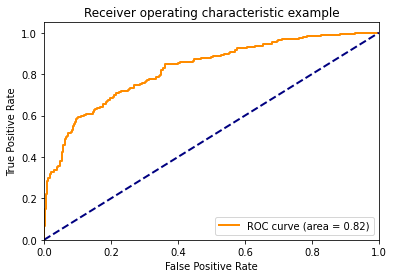

In [ ]:
Y_test_onehot = y_test.copy()
y_proba_pred = np.array(predictions)

from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_test_onehot[:, i], y_proba_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_onehot.ravel(),y_proba_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main__':


<Figure size 864x648 with 0 Axes>

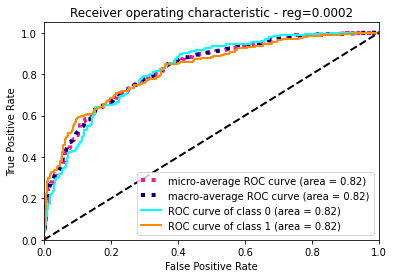

In [ ]:
plt.figure(figsize=(12,9))
n_classes=2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - reg=0.0002')
plt.legend(loc="lower right")
plt.savefig(folder_result+'roc_reg0.0002.png')
plt.show()

## Example Model: 3D CNN in Tensorflow - Training

In [ ]:
num_steps = 700000 #275000 #number of training steps. Divide num_steps by batchsize to obtain epochs
width, height, depth = 64, 64, 44
batchsize = 64

#My advice for the learning rate: define a schedule: after 4000 epochs, divide learning_rate every 500 epochs to avoid overfitting (learning_rate = 0.0000001 is a good place to stop)
learning_rate = 5e-5 #1e-4 too large #0.000025
#regularisation = 0.001 #anything larger than 0.001 usually takes more than 9 hours to have > 0.5 accuracy. If regularisation is high, your initial learning_rate should be large too.

batch_index = 0

def get_data_batch(data_x, data_y, batch_size, width, height, depth):
    global batch_index
    max_ = data_y.shape[1]
    begin = batch_index
    end = batch_index + batch_size
    if end >= max_:
        end = max_
        batch_index = -batch_size
    y_data = data_y[:, begin:end].T
    fetch_data_x= data_x[begin:end,:,:,:]
    batch_index += batch_size
    x_data_= fetch_data_x.reshape(end-begin, width*height*depth)
    return begin, end, x_data_, y_data

def get_random_data_batch(data_x, data_y, batch_size, width, height, depth):
    global batch_index
    max_ = data_y.shape[1]
    begin = batch_index
    end = batch_index + batch_size
    if end >= max_:
        end = max_
        batch_index = -batch_size
    y_data = data_y[:, begin:end].T
    fetch_data_x= data_x[begin:end,:,:,:]
    global X_train
    batch_index = random.randint(0,X_train.shape[0])
    x_data_= fetch_data_x.reshape(end-begin, width*height*depth)
    return begin, end, x_data_, y_data

def weight_variable(shape,name,trainable=True):
    initial = tf.truncated_normal(shape,mean=2,stddev=0.1)*0.01
    return tf.Variable(initial,name = name,trainable=trainable)

def bias_variable(shape,name,trainable=True):
    initial = tf.constant(0.1,shape = shape)
    return tf.Variable(initial, name = name,trainable=trainable)

def stabilizing_constant_variable(shape,name,trainable=False):
    initial = tf.constant(1e-8,shape = shape)
    return tf.Variable(initial, name = name,trainable=trainable)

def conv3d(x,W, strides, paddingtype,name=None):
    return tf.nn.conv3d(x, W, strides=[1,strides[0],strides[1],strides[2],1], padding = paddingtype,name=name)

def max_pool_3D(x,poolsize, strides, paddingtype,name=None):
    return tf.nn.max_pool3d(x,ksize=[1,poolsize[0],poolsize[1],poolsize[2],1],strides=[1,strides[0],strides[1],strides[2],1],padding=paddingtype,name=name)


In [ ]:

os.chdir(folder_root)
tf.reset_default_graph()


def sixth_model(width, height, depth, nlabels, num_steps, folder_root, batchsize, learning_rate, keep_proportion, X_train, y_train, X_val, y_val, X_test, y_test, adaptive=None):
    """
    Argument:
        width, height, depth -- the size of one volume
        nlabels -- the number of labels(here is 3 types of brain activity: negative, positive and rest)
        num_steps -- the number of iterations in training process
        method -- type of method
        folder_root -- root which stores files

    Returns
        the loss and accuracy was stored in a txt file
    """

    adaptive_suffix = ''
    if adaptive != None:
      adaptive_suffix = adaptive

    result_saved_root = folder_result + 'sixth_regularised_' +'allSubjects' + "_lr" + str(learning_rate)+ "_reg"+str(regularisation) + "_n" + str(num_steps) + "_keep"+ str(keep_proportion) +"_first_" +str(n_runs)+"_runs" + adaptive_suffix + '.txt'
    
    if adaptive == '_earlyStopping':
      reult_saved_root = folder_result + 'earlyStopping/' + 'adaptive_fourth_regularised_' +'allSubjects' + "_lr" + str(learning_rate)+ "_reg"+str(regularisation) + "_n" + str(num_steps) + "_keep"+ str(keep_proportion) +"_first_" +str(n_runs)+"_runs" + adaptive_suffix + '.txt'

    print(result_saved_root)
    with open(result_saved_root,'a') as f:
      print(file_list,file=f)

    # build tensorflow CNN
    sess = tf.InteractiveSession()
    # input
    x = tf.placeholder(tf.float32, [None,width*height*depth],name = 'x-input')
    y_ = tf.placeholder(tf.float32, [None,nlabels],name = 'y-input')
    keep_prob = tf.placeholder(tf.float32)  #keep_prob < 1 for training and =1 for validation and testing. keep_prob is deprecated in tf2 (uses rate instead)

    x_image = tf.reshape(x, [-1, width, height, depth, 1])

    ## First Convolutional Layer
    W_conv1 = weight_variable([3, 3, 3, 1, 7],name= 'W_conv1',trainable=True)
    b_conv1 = bias_variable([7],name = 'b_conv1',trainable=True)
    h_conv1 = tf.nn.relu(tf.layers.batch_normalization(conv3d(x_image, W_conv1, [1,1,1], 'VALID') + b_conv1),name= 'h_conv1')
    print('conv1: ',str(h_conv1.get_shape))
    h_pool1 = max_pool_3D(h_conv1, [4,4,4], [4,4,4], 'VALID',name='h_pool1')
    print('pool1: ',str(h_pool1.get_shape))

    ## Second Convolutional Layer
    W_conv2 = weight_variable([3, 3, 3, 7, 64],name= 'W_conv2',trainable=True)
    b_conv2 = bias_variable([64],name = 'b_conv2',trainable=True)
    h_conv2 = tf.nn.relu(tf.layers.batch_normalization(conv3d(h_pool1, W_conv2, [1,1,1], 'VALID') + b_conv2),name='h_conv2')
    print('conv2: ',str(h_conv2.get_shape))
    #h_conv2_drop = tf.nn.dropout(h_conv2,keep_prob=keep_prob) 
    #h_pool2 = max_pool_3D(h_conv2_drop, [4,4,4], [4,4,4], 'VALID')
    h_pool2 = max_pool_3D(h_conv2, [4,4,4], [4,4,4], 'VALID',name='h_pool2')
    print('pool2: ',str(h_pool2.get_shape))

    ## Third Convolutional Layer (1x1x1)
    W_conv3 = weight_variable([1, 1, 1, 64, 8],name= 'W_conv3')
    b_conv3 = bias_variable([8],name = 'b_conv3')
    h_conv3 = tf.nn.relu(tf.layers.batch_normalization(conv3d(h_pool2, W_conv3, [1,1,1], 'VALID') + b_conv3),name='h_conv3')
    print('conv3: ',str(h_conv3.get_shape))
    h_conv3_flat = tf.reshape(h_conv3, [-1, 3*3*2*8])  
    h_conv3_flat_drop = tf.nn.dropout(h_conv3_flat, keep_prob=keep_prob) #keep_prob < 1 for training and =1 for validation and testing
    print('flat: ',str(h_conv3_flat_drop.get_shape))

    ## Readout Layer
    W_fc2 = weight_variable([3*3*2*8, nlabels], name= 'W_out')
    b_fc2 = bias_variable([nlabels], name= 'b_out')

    numerical_stabilizer = stabilizing_constant_variable([nlabels],name='1e-8')

    y_conv = tf.matmul(h_conv3_flat_drop, W_fc2) + b_fc2 + numerical_stabilizer # we add the numerical stabilizer to avoid NaNs due to zero-probability classes
   
    vars   = tf.trainable_variables() 
    print([v.name for v in vars if 'W_' in v.name])
    lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in vars if 'W_' in v.name ]) * regularisation
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_conv),name='cross_entropy')+ lossL2

    #adaptive learning rate
    step = tf.Variable(0, trainable=False)
#    boundaries = [2/3*num_steps, 3/4*num_steps]
    boundaries = [3/5*num_steps, 2/3*num_steps]

    if adaptive == '_increasing':
      #values = [learning_rate, learning_rate*1000, learning_rate*10000]
      values = [learning_rate, learning_rate*10000, learning_rate*100000]
    if adaptive == '_decreasing':
      values = [learning_rate, 5e-10, 4.5e-10]

    if adaptive == None:
      values = [learning_rate,learning_rate,learning_rate]
    print(values)

    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    learning_rate_schedule = learning_rate_fn(step)

    if adaptive == '_earlyStopping':
      callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


    train_step = tf.train.AdamOptimizer(learning_rate_schedule).minimize(cross_entropy)  # 1e-4
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1),name='correct_prediction')
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name='accuracy')

    sess.run(tf.global_variables_initializer())

    path, filename = os.path.split(result_saved_root) #refer to https://stackoverflow.com/questions/10507298/splitting-path-strings-into-drive-path-and-file-name-parts
    tempFilename=os.path.splitext(filename) #refer to https://stackoverflow.com/questions/678236/how-to-get-the-filename-without-the-extension-from-a-path-in-python
    sModelPath = path + "/" + tempFilename[0] #without extension

    steps_to_epoch = len(X_train)//batchsize+1
    print('steps per epoch: ',steps_to_epoch)

    # train
    epoch=0
    prevEpochTime = time.time()
    for step in range(num_steps):
        begin, end, batch_x, batch_y = get_data_batch(X_train, y_train, batchsize, width, height, depth)
        # Run optimization op (backprop)
        sess.run(train_step, feed_dict={x: batch_x, y_: batch_y, keep_prob: keep_proportion}) #keep prob <1 for traing and =1 for validation and testing #0.95 converges by 18000 steps, #0.90 converges before 20000
        if (step == 0) or (step % steps_to_epoch == 0): #validating at each epoch

            # Calculate batch loss and accuracy
            loss, acc = sess.run([cross_entropy, accuracy], feed_dict={x: batch_x, y_: batch_y, keep_prob: 1.0}) #keep_prob should be same as sess.run.

            #Calculate validation loss and accuracy
            startTime = time.time()
            val_loss, val_accuracy=sess.run([cross_entropy,accuracy], feed_dict={x: X_val.reshape(X_val.shape[0], width*height*depth), y_: y_val.T, keep_prob: 1.0})
#            print('val_accuracy : ',val_accuracy,' val_loss :  ',val_loss)
            average_time = (time.time() - startTime) / len(y_val.T)
            with open(result_saved_root, 'a') as f:
                print("Epoch " + str(epoch) + ", Begin: " + str(begin) + ", end: " + str(end) + ', totalTrainSize= ' + str(X_train.shape[0]) + ", Minibatch loss= " +
                    "{:.4f}".format(loss) + ", Training accuracy= " + "{:.3f}".format(acc),", Validation loss= " + "{:.4f}".format(val_loss),", Validation accuracy= " + "{:.3f}".format(val_accuracy),", average validation time = " + "{:.5f}".format(average_time), file=f)
            if acc>=0.85 and val_accuracy>=0.85: #for testing purpose, in reality, need a criteria
                try:
                    oTrainSaver
                except NameError:
                    oTrainSaver=tf.train.Saver()
                save_path = sModelPath + '_' + str(epoch)+'.ckpt'
                oTrainSaver.save(sess, save_path)  # filename ends with .ckpt
                print('Model Saved, acc and val_acc were above threshold.')
            epochTime = time.time() - prevEpochTime
#            print('train epoch time (s): ',str(epochTime))
            prevEpochTime = time.time()
            epoch+=1
         
        #save backup model in case of crash - save every 100 epochs
        if (epoch % 100 == 0) & (step % steps_to_epoch == 0):
            try:
                oTrainSaver
            except NameError:
                oTrainSaver = tf.train.Saver()
            save_path = sModelPath + '_backup'+'.ckpt'
            oTrainSaver.save(sess, save_path)  # filename ends with .ckpt
            print("Backup model was saved: ", epoch, step, val_accuracy, loss, val_loss, val_loss - loss)
            with open(result_saved_root, 'a') as f:
                print("Backup model was saved!", file=f)

    print("Optimization Finished!")
    with open(result_saved_root, 'a') as f:
        print("Optimization Finished!", file=f)
    #save last epoch's model
    try:
        oTrainSaver
    except NameError:
        oTrainSaver = tf.train.Saver()
    save_path = sModelPath + '_lastEpoch'+'.ckpt'
    oTrainSaver.save(sess, save_path)  # filename ends with .ckpt
    print("Trained model was saved!")
    with open(result_saved_root, 'a') as f:
        print("Trained model was saved!", file=f)

    startTime = time.time()
    test_accuracy=sess.run(accuracy, feed_dict={x: X_test.reshape(X_test.shape[0], width*height*depth), y_: y_test.T, keep_prob: 1.0})
    average_time = (time.time() - startTime)/len(y_test.T) #seconds per sample
    print("......Testing accuracy using the last epoch training model:", test_accuracy)
    
    predictions = sess.run(tf.argmax(y_conv,1),feed_dict={x:X_test.reshape(X_test.shape[0], width*height*depth), y_: y_test.T, keep_prob: 1.0})
    with open(result_saved_root, 'a') as f:
        print(".......Testing result using the last epoch training model......", file=f)
        print("...Testing accuracy:" + "{:.3f}".format(test_accuracy)+", average testing time = " + "{:.5f}".format(average_time), file=f)
        print("Test predictions:",predictions,file=f) #We need these predictions to plot the confusion matrix and ROC curves

if __name__ == '__main__':
  for keep_proportion in [0.5]:
      for regularisation in [0.01]:
        for adaptive in [None]:
          tf.reset_default_graph()
          batch_index = 0
          sixth_model(width, height, depth, nlabels, num_steps, folder_root, batchsize, learning_rate, keep_proportion=keep_proportion, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test, adaptive=adaptive)


/content/drive/My Drive/Max/result/sixth_model/sixth_regularised_allSubjects_lr5e-05_reg0.01_n700000_keep0.5_first_39_runs.txt
conv1:  <bound method Tensor.get_shape of <tf.Tensor 'h_conv1:0' shape=(?, 62, 62, 42, 7) dtype=float32>>
pool1:  <bound method Tensor.get_shape of <tf.Tensor 'h_pool1:0' shape=(?, 15, 15, 10, 7) dtype=float32>>
conv2:  <bound method Tensor.get_shape of <tf.Tensor 'h_conv2:0' shape=(?, 13, 13, 8, 64) dtype=float32>>
pool2:  <bound method Tensor.get_shape of <tf.Tensor 'h_pool2:0' shape=(?, 3, 3, 2, 64) dtype=float32>>
conv3:  <bound method Tensor.get_shape of <tf.Tensor 'h_conv3:0' shape=(?, 3, 3, 2, 8) dtype=float32>>
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:308: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


flat:  <bound method Tensor.get_shape of <tf.Tensor 'dropout/Mul:0' shape=(?, 144) dtype=float32>>
['W_conv1:0', 'W_conv2:0', 'W_conv3:0', 'W_out:0']
[5e-05, 5e-05, 5e-05]
steps per epoch:  31
Backup model was saved:  100 3069 0.50409836 0.69360876 0.6942784 0.0006696582
Backup model was saved:  200 6169 0.50409836 0.6932941 0.69411546 0.000821352
Backup model was saved:  300 9269 0.50409836 0.69338053 0.69380754 0.00042700768
Backup model was saved:  400 12369 0.50409836 0.6932676 0.6937672 0.00049960613
Backup model was saved:  500 15469 0.50409836 0.6931809 0.6937204 0.00053948164
Backup model was saved:  600 18569 0.50409836 0.6932435 0.69358736 0.0003438592
Backup model was saved:  700 21669 0.50409836 0.6929586 0.6934772 0.00051862
Backup model was saved:  800 24769 0.50409836 0.69268626 0.6934556 0.00076931715
Backup model was saved:  900 27869 0.50409836 0.69282085 0.6933602 0.00053936243
Backup model was saved:  1000 30969 0.50409836 0.6924995 0.6934183 0.0009188056
Backup mod

## Example Model: 3D CNN in Tensorflow - Plot Graphs

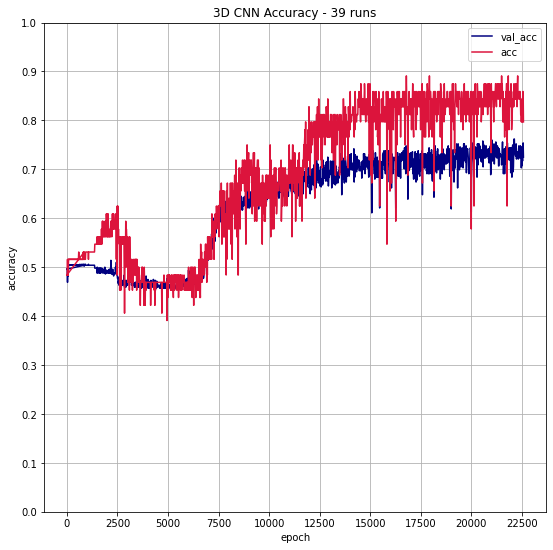

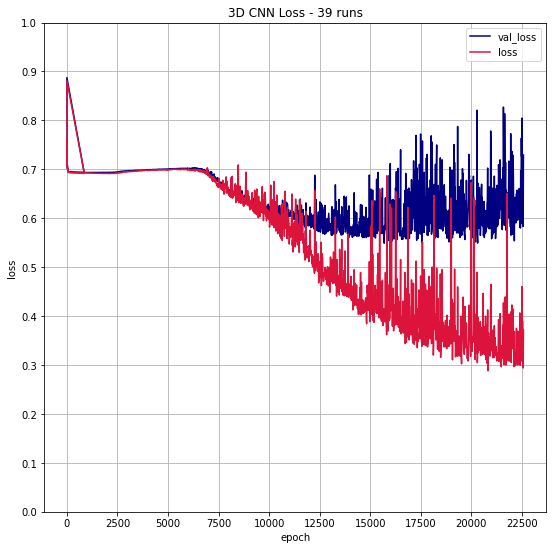

In [ ]:
os.chdir(folder_result)

filename = 'sixth_regularised_allSubjects_lr5e-05_reg0.01_n700000_keep0.5_first_39_runs.txt'
    
with open(filename,'r') as f:
  lines = f.readlines()
epoch_list = []
train_accuracy_list = []
validation_accuracy_list = []
loss_list = []
validation_loss_list = []
for line in lines:
  if line[:5]=='Epoch':
    line_split = line.split(' ')
    for i in range(len(line_split)):
      if line_split[i] == 'Epoch':
        epoch_list.append(int(line_split[i+1][:-1]))
      if line_split[i] == 'Minibatch':#Minibatch Loss=
        loss_list.append(float(line_split[i+2][:-1]))
      if line_split[i] == 'Training':#Training accuracy
        train_accuracy_list.append(float(line_split[i+2]))
      if line_split[i] == "Validation":
        if line_split[i+1] == "loss=":
          validation_loss_list.append(float(line_split[i+2]))
        if line_split[i+1] == "accuracy=":
          validation_accuracy_list.append(float(line_split[i+2]))
      
train_result = pd.DataFrame({'epoch':epoch_list,'val_acc':validation_accuracy_list,'acc':train_accuracy_list,'loss':loss_list,'val_loss':validation_loss_list})[1::15]
ax = plt.figure(0,figsize=(9,9)).gca()
ax.plot('epoch','val_acc',data=train_result,color='navy')
ax.plot('epoch','acc',data=train_result,color='crimson')
plt.title('3D CNN Accuracy - '+str(n_runs)+' runs')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.legend()
plt.grid()
ax.set_yticks(np.arange(0,1.1,0.1))

ax2 = plt.figure(1,figsize=(9,9)).gca()
plt.title('3D CNN Loss - '+str(n_runs)+' runs')
ax2.plot('epoch','val_loss',data=train_result,color='navy')
ax2.plot('epoch','loss',data=train_result,color='crimson')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_yticks(np.arange(0,1.1,0.1))

ax2.legend()
plt.grid()

plt.show()

## Example Model: 3D CNN in Tensorflow - Load model from last checkpoint and re-train 



In [ ]:
### RELOAD AND CONTINUE TRAINING ####

os.chdir(folder_root)
tf.reset_default_graph()

def model_retrain_with_dropout(width, height, depth, nlabels, num_steps, folder_root, batchsize, learning_rate, keep_proportion, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test, adaptive=None, savedModelSuffix='_lastEpoch'):
  
    # build tensorflow CNN
    adaptive_suffix = ''
    if adaptive != None:
      adaptive_suffix = adaptive

    result_saved_root = folder_result + 'sixth_regularised_' +'allSubjects' + "_lr" + str(learning_rate)+ "_reg"+str(regularisation) + "_n" + str(num_steps) + "_keep"+ str(keep_proportion) +"_first_" +str(n_runs)+"_runs" + adaptive_suffix + '.txt'
    
    if adaptive == '_earlyStopping':
      reult_saved_root = folder_result + 'earlyStopping/' + 'adaptive_fourth_regularised_' +'allSubjects' + "_lr" + str(learning_rate)+ "_reg"+str(regularisation) + "_n" + str(num_steps) + "_keep"+ str(keep_proportion) +"_first_" +str(n_runs)+"_runs" + adaptive_suffix + '.txt'

    print(result_saved_root)
    with open(result_saved_root,'a') as f:
      print('',file=f)
      print('RELOADED',file=f)
      print('',file=f)
      print(file_list,file=f)

    # build tensorflow CNN
    sess = tf.InteractiveSession()
    # input
    x = tf.placeholder(tf.float32, [None,width*height*depth],name = 'x-input')
    y_ = tf.placeholder(tf.float32, [None,nlabels],name = 'y-input')
    keep_prob = tf.placeholder(tf.float32)  #keep_prob < 1 for training and =1 for validation and testing. keep_prob is deprecated in tf2 (uses rate instead)

    x_image = tf.reshape(x, [-1, width, height, depth, 1])

    ## First Convolutional Layer
    W_conv1 = weight_variable([3, 3, 3, 1, 7],name= 'W_conv1',trainable=True)
    b_conv1 = bias_variable([7],name = 'b_conv1',trainable=True)
    h_conv1 = tf.nn.relu(tf.layers.batch_normalization(conv3d(x_image, W_conv1, [1,1,1], 'VALID') + b_conv1),name= 'h_conv1')
    print('conv1: ',str(h_conv1.get_shape))
    h_pool1 = max_pool_3D(h_conv1, [4,4,4], [4,4,4], 'VALID',name='h_pool1')
    print('pool1: ',str(h_pool1.get_shape))

    ## Second Convolutional Layer
    W_conv2 = weight_variable([3, 3, 3, 7, 64],name= 'W_conv2',trainable=True)
    b_conv2 = bias_variable([64],name = 'b_conv2',trainable=True)
    h_conv2 = tf.nn.relu(tf.layers.batch_normalization(conv3d(h_pool1, W_conv2, [1,1,1], 'VALID') + b_conv2),name='h_conv2')
    print('conv2: ',str(h_conv2.get_shape))
    #h_conv2_drop = tf.nn.dropout(h_conv2,keep_prob=keep_prob) 
    #h_pool2 = max_pool_3D(h_conv2_drop, [4,4,4], [4,4,4], 'VALID')
    h_pool2 = max_pool_3D(h_conv2, [4,4,4], [4,4,4], 'VALID',name='h_pool2')
    print('pool2: ',str(h_pool2.get_shape))

    ## Third Convolutional Layer (1x1x1)
    W_conv3 = weight_variable([1, 1, 1, 64, 8],name= 'W_conv3')
    b_conv3 = bias_variable([8],name = 'b_conv3')
    h_conv3 = tf.nn.relu(tf.layers.batch_normalization(conv3d(h_pool2, W_conv3, [1,1,1], 'VALID') + b_conv3),name='h_conv3')
    print('conv3: ',str(h_conv3.get_shape))
    h_conv3_flat = tf.reshape(h_conv3, [-1, 3*3*2*8])  
    h_conv3_flat_drop = tf.nn.dropout(h_conv3_flat, keep_prob=keep_prob) #keep_prob < 1 for training and =1 for validation and testing
    print('flat: ',str(h_conv3_flat_drop.get_shape))

    ## Readout Layer
    W_fc2 = weight_variable([3*3*2*8, nlabels], name= 'W_out')
    b_fc2 = bias_variable([nlabels], name= 'b_out')

    numerical_stabilizer = stabilizing_constant_variable([nlabels],name='1e-8')

    y_conv = tf.matmul(h_conv3_flat_drop, W_fc2) + b_fc2 + numerical_stabilizer # we add the numerical stabilizer to avoid NaNs due to zero-probability classes
   
    vars   = tf.trainable_variables() 
    print([v.name for v in vars if 'W_' in v.name])
    lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in vars if 'W_' in v.name ]) * regularisation
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_conv),name='cross_entropy')+ lossL2

    #adaptive learning rate
    step = tf.Variable(0, trainable=False)
#    boundaries = [2/3*num_steps, 3/4*num_steps]
    boundaries = [3/5*num_steps, 2/3*num_steps]

    if adaptive == '_increasing':
      #values = [learning_rate, learning_rate*1000, learning_rate*10000]
      values = [learning_rate, learning_rate*10000, learning_rate*100000]
    if adaptive == '_decreasing':
      values = [learning_rate, 5e-10, 4.5e-10]

    if adaptive == None:
      values = [learning_rate,learning_rate,learning_rate]
    print(values)

    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    learning_rate_schedule = learning_rate_fn(step)

    if adaptive == '_earlyStopping':
      callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


    train_step = tf.train.AdamOptimizer(learning_rate_schedule).minimize(cross_entropy)  # 1e-4
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1),name='correct_prediction')
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name='accuracy')

    sess.run(tf.global_variables_initializer())
    path, filename = os.path.split(result_saved_root) #refer to https://stackoverflow.com/questions/10507298/splitting-path-strings-into-drive-path-and-file-name-parts
    tempFilename=os.path.splitext(filename) #refer to https://stackoverflow.com/questions/678236/how-to-get-the-filename-without-the-extension-from-a-path-in-python
    sModelPath = path + "/" + tempFilename[0] #without extension

    steps_to_epoch = len(X_train)//batchsize+1
    print('steps for each epoch: ',steps_to_epoch)
    # train
    epoch = latest_epoch #defined outside of this function

    #Loads model
    save_path = sModelPath +savedModelSuffix+'.ckpt'
    try:
      oTrainSaver
    except NameError:
      oTrainSaver = tf.train.Saver()

    oTrainSaver.restore(sess, save_path)  # filename ends with .ckpt
    print("Successfully Loaded trained model from "+save_path)

    prevEpochTime = time.time()
   
    for step in range(latest_step, final_step):
      
        begin, end, batch_x, batch_y = get_data_batch(X_train, y_train, batchsize, width, height, depth)
        # Run optimization op (backprop)
        sess.run(train_step, feed_dict={x: batch_x, y_: batch_y, keep_prob: keep_proportion}) #keep prob <1 for traing and =1 for validation and testing #0.95 converges by 18000 steps, #0.90 converges before 20000
        if (step == 0) or (step % steps_to_epoch == 0): #validating at each epoch

            # Calculate batch loss and accuracy
            loss, acc = sess.run([cross_entropy, accuracy], feed_dict={x: batch_x, y_: batch_y, keep_prob: 1.0}) #keep_prob should be same as sess.run.

            #Calculate validation loss and accuracy
            startTime = time.time()
            val_loss, val_accuracy=sess.run([cross_entropy,accuracy], feed_dict={x: X_val.reshape(X_val.shape[0], width*height*depth), y_: y_val.T, keep_prob: 1.0})
#            print('val_accuracy : ',val_accuracy,' val_loss :  ',val_loss)
            average_time = (time.time() - startTime) / len(y_val.T)
            with open(result_saved_root, 'a') as f:
                print("Epoch " + str(epoch) + ", Begin: " + str(begin) + ", end: " + str(end) + ', totalTrainSize= ' + str(X_train.shape[0]) + ", Minibatch loss= " +
                    "{:.4f}".format(loss) + ", Training accuracy= " + "{:.3f}".format(acc),", Validation loss= " + "{:.4f}".format(val_loss),", Validation accuracy= " + "{:.3f}".format(val_accuracy),", average validation time = " + "{:.5f}".format(average_time), file=f)
            if acc>=0.85 and val_accuracy>=0.85: #for testing purpose, in reality, need a criteria
                try:
                    oTrainSaver
                except NameError:
                    oTrainSaver=tf.train.Saver()
                save_path = sModelPath + '_' + str(epoch)+'.ckpt'
                oTrainSaver.save(sess, save_path)  # filename ends with .ckpt
                print('Model Saved, acc and val_acc were above threshold.')
            epochTime = time.time() - prevEpochTime
#            print('train epoch time (s): ',str(epochTime))
            prevEpochTime = time.time()
            epoch+=1
         
        #save backup model in case of crash - save every 100 epochs
        if (epoch % 100 == 0) & (step % steps_to_epoch == 1):
            try:
                oTrainSaver
            except NameError:
                oTrainSaver = tf.train.Saver()
            save_path = sModelPath + '_backup'+'.ckpt'
            oTrainSaver.save(sess, save_path)  # filename ends with .ckpt
            print("Backup model was saved: ", epoch, step, val_accuracy, val_loss - loss,val_loss)
            with open(result_saved_root, 'a') as f:
                print("Backup model was saved!", file=f)

    print("Optimization Finished!")
    with open(result_saved_root, 'a') as f:
        print("Optimization Finished!", file=f)
    #save last epoch's model
    try:
        oTrainSaver
    except NameError:
        oTrainSaver = tf.train.Saver()
    save_path = sModelPath + '_lastEpoch'+'.ckpt'
    oTrainSaver.save(sess, save_path)  # filename ends with .ckpt
    print("Trained model was saved!")
    with open(result_saved_root, 'a') as f:
        print("Trained model was saved!", file=f)

    startTime = time.time()
    test_accuracy=sess.run(accuracy, feed_dict={x: X_test.reshape(X_test.shape[0], width*height*depth), y_: y_test.T, keep_prob: 1.0})
    average_time = (time.time() - startTime)/len(y_test.T) #seconds per sample
    print("......Testing accuracy using the last epoch training model:", test_accuracy)
    
    predictions = sess.run(tf.argmax(y_conv,1),feed_dict={x:X_test.reshape(X_test.shape[0], width*height*depth), y_: y_test.T, keep_prob: 1.0})
    with open(result_saved_root, 'a') as f:
        print(".......Testing result using the last epoch training model......", file=f)
        print("...Testing accuracy:" + "{:.3f}".format(test_accuracy)+", average testing time = " + "{:.5f}".format(average_time), file=f)
        print("Test predictions:",predictions,file=f) #We need these predictions to plot the confusion matrix and ROC curves


if __name__ == '__main__':
    final_step = 700000
    latest_epoch = 12903 # TODO: set the starting epoch of retraining as the last epoch from the model you are about to load. Can be lastEpoch, backup epoch, or any epoch associated with a saved model. DO NOT FORGET TO UPDATE IT WHEN YOU LOAD A NEW MODEL.
    latest_step = 400000  # TODO
#    savedModelSuffix = # TODO: use one of the three following options: '_lastEpoch', '_backup' or '_'+str(latest_epoch). See the comments below.
 
    savedModelSuffix='_lastEpoch'  # you are reloading from a model that was successfully trained until the last epoch
    #savedModelSuffix='_backup'  # you are reloading from a backup model because training crashed before the last epoch
    #savedModelSuffix='_'+str(latest_epoch) # you are reloading from a model that achieved a high validation and training accuracy (>85%)

    num_steps =400000

    learning_rate = 5e-5
    tf.reset_default_graph()
    batch_index = 0

    for keep_proportion in [0.5]:
      for regularisation in [0.01]:
        print('reloaded from :',savedModelSuffix)
        model_retrain_with_dropout(width, height, depth, nlabels, num_steps, folder_root, batchsize, learning_rate, keep_proportion, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test, adaptive=None, savedModelSuffix=savedModelSuffix)


NameError: ignored